In [1]:
import random
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from skimage.metrics import structural_similarity as ssim
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
import copy

In [3]:
img_path = r'CHASEDB1/Image_01R.jpg'
ground_img_path = r'CHASEDB1/Image_01R_1stHO.png'

img = Image.open(img_path)
ground_img = Image.open(ground_img_path)

img_array = np.array(img)
ground_img_array = np.array(ground_img)

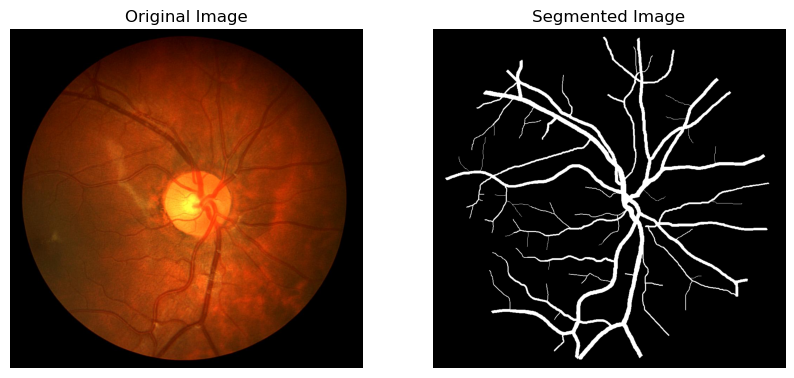

In [4]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(img_array)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(ground_img_array, cmap='grey')
plt.title("Segmented Image")
plt.axis('off')

plt.show()

In [5]:
def accuracy_func(image1, image2):

    segmented_vessels = image1
    segmented_image = image2

    ssim_score = ssim(segmented_image, segmented_vessels, data_range=255)
    psnr_score = float('inf')
    mse = np.mean((image1 - image2) ** 2)
    if mse != 0:
        max_pixel = 255.0
        psnr_score = 20 * np.log10(max_pixel / np.sqrt(mse))

    generated_binary = (segmented_vessels > 0).astype(np.uint8)
    target_binary = (segmented_image > 0).astype(np.uint8)

    tn, fp, fn, tp = confusion_matrix(target_binary.ravel(), generated_binary.ravel()).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = 2/((1/specificity)+(1/sensitivity))
    
    print(f'SSIM: {ssim_score:.4f}')
    print(f'PSNR: {psnr_score:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')
    print(f'f1: {f1:.4f}')

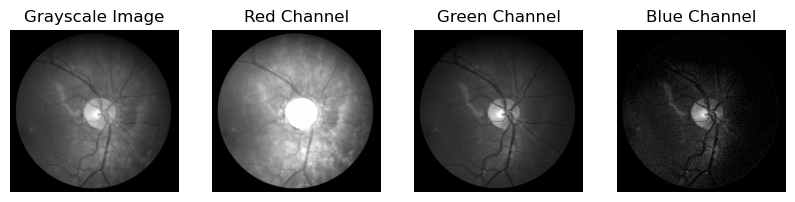

In [6]:
img_gray = img.convert('L')
img_gray_array = np.array(img_gray)

red_channel = img_array[:, :, 0]
green_channel = img_array[:, :, 1]
blue_channel = img_array[:, :, 2]

plt.figure(figsize=(10, 5))

plt.subplot(1, 4, 1)
plt.imshow(img_gray, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(red_channel, cmap='gray')
plt.title('Red Channel')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(green_channel, cmap='gray')
plt.title('Green Channel')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(blue_channel, cmap='gray')
plt.title('Blue Channel')
plt.axis('off')

plt.show()

In [7]:
green_channel = img_array[:, :, 1]

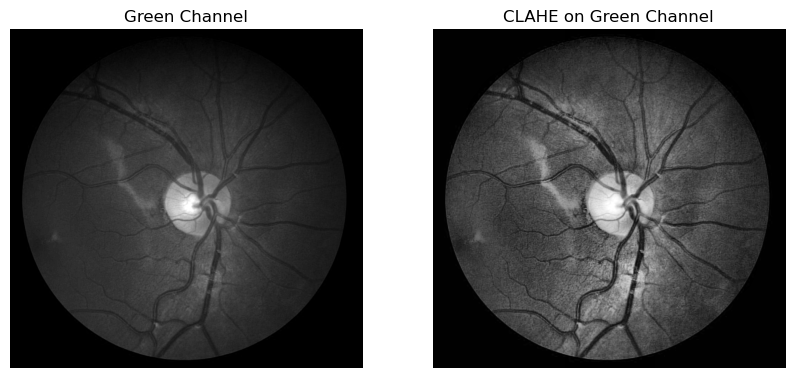

In [25]:
# Apply Random CLAHE with Varying Clip Limit
random_clip_limit = random.uniform(2, 5)  # Randomly select clip limit between 2 and 5
clahe = cv2.createCLAHE(clipLimit=random_clip_limit, tileGridSize=(8, 8))
cl_img_green = clahe.apply(green_channel)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(green_channel, cmap='gray')
plt.title('Green Channel')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cl_img_green, cmap='gray')
plt.title('CLAHE on Green Channel')
plt.axis('off')

plt.show()

In [26]:
cell_disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))

Topen = cv2.morphologyEx(green_channel,cv2.MORPH_OPEN,cell_disc)
Tclose = cv2.morphologyEx(Topen, cv2.MORPH_CLOSE, cell_disc)
TopHat = (green_channel - Tclose)#.astype(np.uint8)
min_image = cv2.erode(TopHat, kernel)
min_image = cv2.dilate(min_image, kernel)

Topen_clahe = cv2.morphologyEx(cl_img_green,cv2.MORPH_OPEN,cell_disc)
Tclose_clahe = cv2.morphologyEx(Topen_clahe, cv2.MORPH_CLOSE, cell_disc)
TopHat_clahe = (cl_img_green - Tclose_clahe)#.astype(np.uint8)
min_image_clahe = cv2.erode(TopHat_clahe, kernel)
min_image_clahe = cv2.dilate(min_image_clahe, kernel)

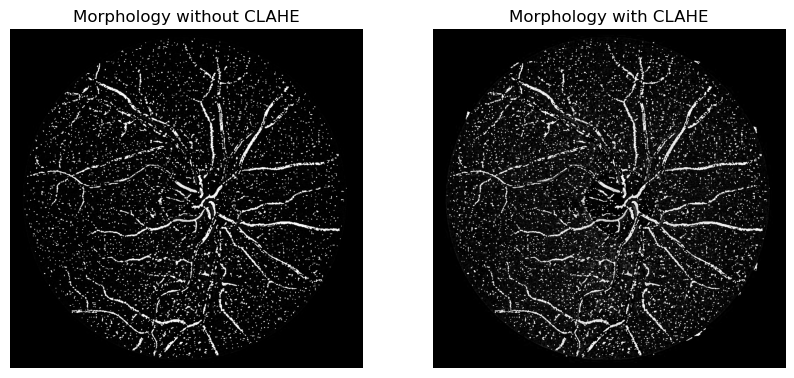

In [27]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(min_image, cmap='gray')
plt.title('Morphology without CLAHE')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(min_image_clahe, cmap='gray')
plt.title('Morphology with CLAHE')
plt.axis('off')

plt.show()

In [28]:
def threshold(img,k):
    ret = copy.deepcopy(img)
    ret[ret<k] = 0
    ret[ret>=k] = 255
    return ret

def GlobalOtsu(img):
    foreground = img[img>=0]
    background = img[img<0]
    
    final_var = (np.var(foreground) * len(foreground) + np.var(background) * len(background))/(len(foreground) + len(background))
    if(np.isnan(final_var)):
        final_var = -1
        
    final_thresh = 0
    for i in np.linspace(np.min(img), np.max(img), num=255):
        foreground = img[img>=i]
        background = img[img<i]
        var = (np.var(foreground) * len(foreground) + np.var(background) * len(background))/(len(foreground) + len(background))
        
        if(np.isnan(var)):
            var = -1
            
        if(var!=-1 and (var<final_var or final_var ==-1)):
            final_var = var
            final_thresh = i
    return threshold(img,final_thresh)

In [29]:
HessWide = hessian_matrix(min_image, sigma=4, order='rc')
EignWide = hessian_matrix_eigvals(HessWide) [1]
HessWide_clahe = hessian_matrix(min_image_clahe, sigma=4, order='rc')
EignWide_clahe = hessian_matrix_eigvals(HessWide_clahe) [1]

val = GlobalOtsu(1-EignWide)
val_clahe = GlobalOtsu(1-EignWide_clahe)

/var/folders/42/82sbd7wn60q49lpf25t_3jdc0000gn/T/ipykernel_47157/2810804449.py:1: FutureWarning: use_gaussian_derivatives currently defaults to False, but will change to True in a future version. Please specify this argument explicitly to maintain the current behavior
  HessWide = hessian_matrix(min_image, sigma=4, order='rc')
/var/folders/42/82sbd7wn60q49lpf25t_3jdc0000gn/T/ipykernel_47157/2810804449.py:3: FutureWarning: use_gaussian_derivatives currently defaults to False, but will change to True in a future version. Please specify this argument explicitly to maintain the current behavior
  HessWide_clahe = hessian_matrix(min_image_clahe, sigma=4, order='rc')
/Users/parthivdholaria/Desktop/BTP/env/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:4008: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/parthivdholaria/Desktop/BTP/env/lib/python3.11/site-packages/numpy/_core/_methods.py:175: RuntimeWarni

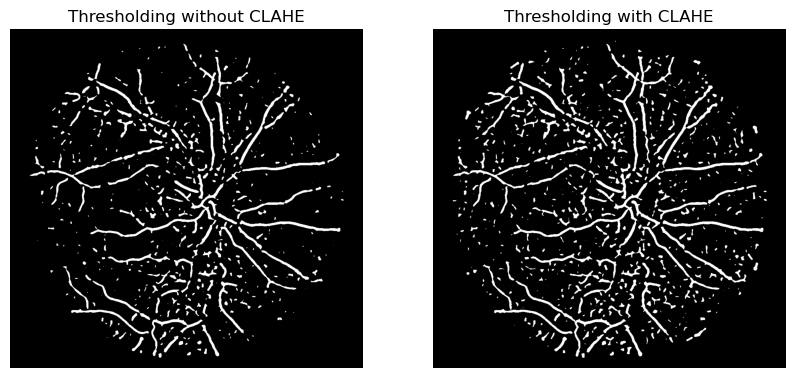

In [30]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(val, cmap='gray')
plt.title('Thresholding without CLAHE')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(val_clahe, cmap='gray')
plt.title('Thresholding with CLAHE')
plt.axis('off')

plt.show()

In [31]:
print("Accuracy without CLAHE")
accuracy_func(ground_img_array,val)

Accuracy without CLAHE
SSIM: 0.8096
PSNR: 11.7395
Accuracy: 0.9346
Sensitivity: 0.5781
Specificity: 0.9603
f1: 0.7217


In [32]:
print("Accuracy with CLAHE")
accuracy_func(ground_img_array,val_clahe)

Accuracy with CLAHE
SSIM: 0.7545
PSNR: 10.6425
Accuracy: 0.9227
Sensitivity: 0.4920
Specificity: 0.9635
f1: 0.6513


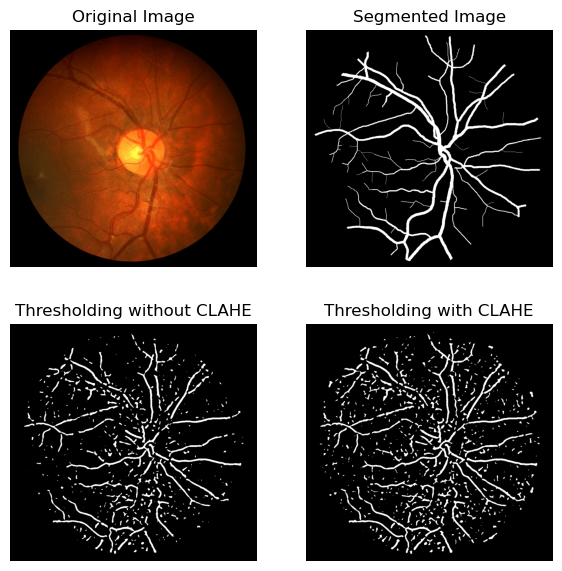

In [33]:
plt.figure(figsize=(7, 7))

plt.subplot(2,2,1)
plt.imshow(img_array)
plt.title("Original Image")
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(ground_img_array, cmap='grey')
plt.title("Segmented Image")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(val, cmap='gray')
plt.title('Thresholding without CLAHE')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(val_clahe, cmap='gray')
plt.title('Thresholding with CLAHE')
plt.axis('off')

plt.show()